In [4]:
from ftpr.visualization import PhaseVisualizer
from mplsoccer import Pitch
import pandas as pd
from ftpr.dataloader import load_phases
from ftpr.representation import PlayerDescretizer, MultiParallelDescritizer, EventDescretizer, LocationDescretizer, CMSPADEWriter
from ftpr.miner import find_patterns, rank_patterns, run_miner
from ftpr.preprocessing import PhaseExtractor
from ftpr.clustering import PhaseClustering
import numpy as np
import pickle
import os

In [5]:
team = 'Manchester City'
phases_dir = os.path.join('..', 'data', 'team_phases')
players_pkl_path = os.path.join('..', 'data', 'players.pkl')

In [6]:
team = 'Manchester City'
df = pd.read_csv(os.path.join(phases_dir, f'{team}.csv'))
phases = load_phases(df, filter_static_events=True, min_phase_length=3, n_jobs=5)
with open(players_pkl_path, 'rb') as f:
	players = list(pickle.load(f)[team])

In [7]:
phases_in_cluster = phases

In [8]:
clustering = PhaseClustering(phases)

In [9]:
n_clusters = 100
cls_pred, agg_clustering = clustering.agglomerative_fit(n_clusters=n_clusters, metric='dtw')

In [10]:
cluster_scores = clustering.get_cluster_scores(metric='shot')
best_cluster_indeces = np.argsort(cluster_scores)[::-1]

In [11]:
ith = 6
phases_in_cluster = clustering.get_cluster_phases(best_cluster_indeces[ith])
series_in_cluster = clustering.get_cluster_series(best_cluster_indeces[ith])

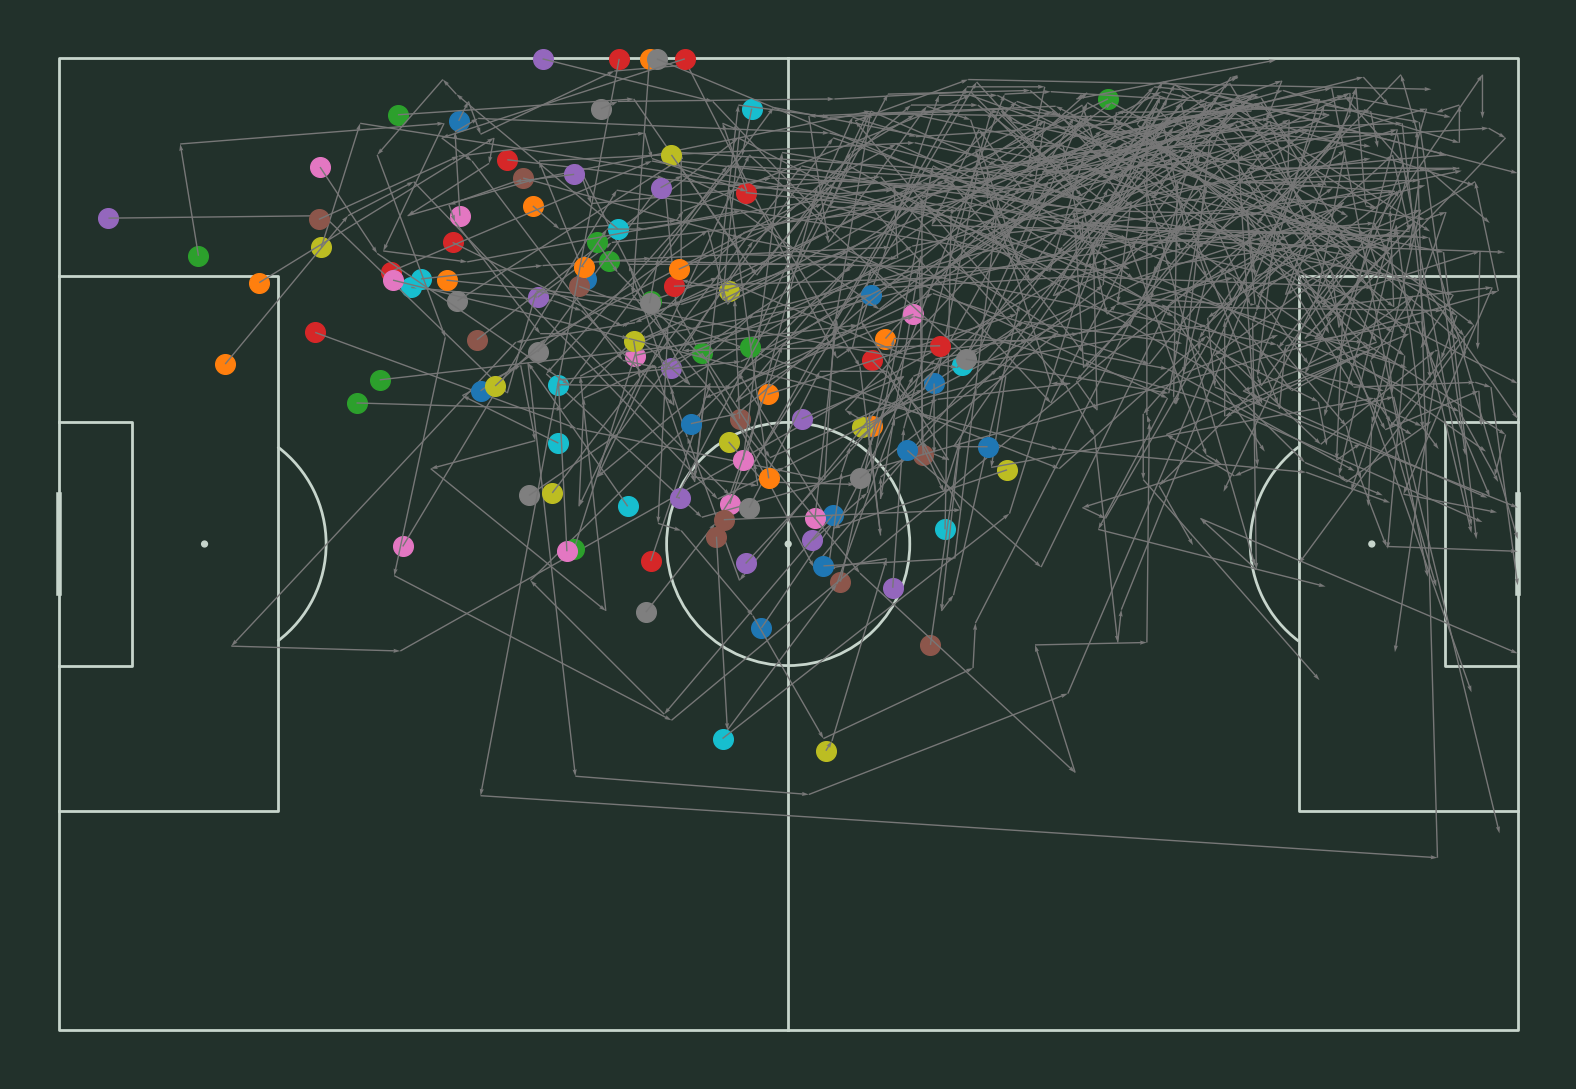

In [12]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

pv = PhaseVisualizer((8, 5))
	
for ser in series_in_cluster:
    pitch.scatter(ser[0, 0], ser[0, 1], s=200, ax=ax)
    for i in range(len(ser) - 1):
        pitch.arrows(ser[i, 0], ser[i, 1], ser[i + 1, 0], ser[i + 1, 1],
                        color='#777777', ax=ax, width=1)


In [13]:
event_types = {
	'pass': ['corner', 'free kick', 'goal kick', 'interception', 'kick off', 'recovery', 'throw-in']
}
event_des = EventDescretizer('event', events=PhaseExtractor.HAVING_BALL_EVENTS, event_types=event_types)
location_des = LocationDescretizer('location')
player_des = PlayerDescretizer('player', players)
multi_des = MultiParallelDescritizer('multi', descretizers=[event_des, location_des])

In [14]:
players

['Samir Nasri',
 'Joe Hart',
 'Manuel García Alonso',
 'Martín Gastón Demichelis',
 'Raheem Sterling',
 'Jesús Navas González',
 'Kevin De Bruyne',
 'Vincent Kompany',
 'Wilfredo Daniel Caballero',
 'Sergio Leonel Agüero del Castillo',
 'Wilfried Guemiand Bony',
 'Pablo Javier Zabaleta Girod',
 'Fabian Delph',
 'Gnégnéri Yaya Touré',
 'Aleksandar Kolarov',
 'Fernando Francisco Reges',
 'Eliaquim Mangala',
 'Fernando Luiz Rosa',
 'Bersant Celina',
 'David Josué Jiménez Silva',
 'Patrick Roberts',
 'Bacary Sagna',
 'Gaël Clichy',
 'Kelechi Promise Iheanacho',
 'Nicolás Hernán Otamendi']

In [15]:
next(multi_des.apply([phases_in_cluster[2]]))

[7, 13, 16, 0, 20, 7, 20, 0, 18, 7, 20, 7, 20]

In [16]:
mapping = multi_des.get_decode_mapping()
mapping

{0: 'carry',
 1: 'ball recovery',
 2: 'goal keeper',
 3: 'clearance',
 4: 'interception',
 5: 'dribble',
 6: 'shot',
 7: 'pass',
 8: 'pass_corner',
 9: 'pass_free kick',
 10: 'pass_goal kick',
 11: 'pass_interception',
 12: 'pass_kick off',
 13: 'pass_recovery',
 14: 'pass_throw-in',
 15: 'block',
 16: 'Left Flank',
 17: 'Right Flank',
 18: 'Own box',
 19: 'Opposition box',
 20: 'Midfield'}

In [17]:
scores = {
    0: 0.5,
	1: 1,
	2: 0.25,
	3: 1,
	4: 1,
	5: 0.5,
	6: 2,
	7: 0.5,
	8: 0.5,
	9: 0.5,
	10: 0.5,
	11: 0.5,
	12: 0.5,
	13: 0.5,
 	14: 0.5,
	15: 0.25
}

In [18]:
scores = {key:0.5 for key in mapping}

In [19]:
writer = CMSPADEWriter()

In [20]:
multi_des.apply(phases_in_cluster)

<generator object Descretizer.apply at 0x14eb99350>

In [21]:
writer.write(multi_des.apply(phases_in_cluster, mode='parallel'), 'testtt.txt')

In [22]:
df = run_miner(algorithm="VMSP", input_filename="testtt.txt",
            output_filename="output.txt", arguments=["5%", "100", "1"])

>/Users/bobby/Desktop/Projects/ftpr/notebooks/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 6122 ms
 Frequent sequences count : 1949
 Max memory (mb) : 76.283386230468751949
minsup 6
Intersection count 233267 




# Analyzing the Result

In [23]:
df['sup'] = df['sup'] / len(phases_in_cluster)
df

,pattern,sup
5,[7 9 20],0.085714
45,"[7, 0 19, 7 19]",0.085714
848,"[1, 0, 7, 0, 7, 0, 7, 0, 7]",0.076190
454,"[0, 7, 0 16, 7, 20, 7 20]",0.076190
222,"[7, 20, 7 20, 0, 7, 20]",0.076190
...,...,...
721,"[0, 7, 16, 16, 7, 0 16, 7 16]",0.057143
720,"[7 16, 7 16, 0 16, 7 16, 0]",0.057143
719,"[16, 16, 7, 0, 7, 0, 7, 16, 16]",0.057143
718,"[0, 7, 16, 16, 7 16, 0 16, 7]",0.057143


In [24]:
find_patterns(df, '6')

,pattern,sup
0,[6],0.057143


In [25]:
scores[6] = 2

In [26]:
df = rank_patterns(df, scores, mapping, 'Custom')
df

,pattern,translate,score
593,[6],"[(shot,)]",0.114286
0,[7 9 20],"[(pass, pass_free kick, Midfield)]",0.042857
1,"[7, 0 19, 7 19]","[(pass,), (carry, Opposition box), (pass, Oppo...",0.042857
16,"[16, 16, 7 16, 0, 19]","[(Left Flank,), (Left Flank,), (pass, Left Fla...",0.038095
28,"[7, 16, 7, 20, 7 20, 16]","[(pass,), (Left Flank,), (pass,), (Midfield,),...",0.038095
...,...,...,...
792,"[7 20, 0, 16, 0 16, 7 16, 0 16, 7 16, 0 16]","[(pass, Midfield), (carry,), (Left Flank,), (c...",0.028571
791,"[7 20, 0, 7, 0, 7, 16, 7 16, 0 16, 7 16, 16]","[(pass, Midfield), (carry,), (pass,), (carry,)...",0.028571
790,"[7 20, 0, 7, 0, 7, 0 16, 7 16, 16, 7 16, 16]","[(pass, Midfield), (carry,), (pass,), (carry,)...",0.028571
789,"[7, 0 16, 16, 0 16, 7 16, 0 16, 7 16, 0 16]","[(pass,), (carry, Left Flank), (Left Flank,), ...",0.028571


In [27]:
find_patterns(df, '6')

,pattern,translate,score
593,[6],"[(shot,)]",0.114286


In [28]:
for t in df.iloc[:10]['translate']:
    print(t)

[('shot',)]
[('pass', 'pass_free kick', 'Midfield')]
[('pass',), ('carry', 'Opposition box'), ('pass', 'Opposition box')]
[('Left Flank',), ('Left Flank',), ('pass', 'Left Flank'), ('carry',), ('Opposition box',)]
[('pass',), ('Left Flank',), ('pass',), ('Midfield',), ('pass', 'Midfield'), ('Left Flank',)]
[('Midfield',), ('Midfield',), ('pass', 'Midfield'), ('carry', 'Left Flank'), ('Left Flank',), ('carry', 'Left Flank'), ('pass', 'Left Flank'), ('carry',)]
[('Midfield',), ('Midfield',), ('pass', 'Midfield'), ('Left Flank',), ('Left Flank',), ('carry', 'Left Flank'), ('pass', 'Left Flank'), ('carry',)]
[('Left Flank',), ('Left Flank',), ('Left Flank',), ('Left Flank',), ('pass',), ('carry', 'Opposition box')]
[('Midfield',), ('Midfield',), ('pass', 'Midfield'), ('carry', 'Left Flank'), ('Left Flank',), ('Left Flank',), ('pass', 'Left Flank'), ('carry',)]
[('pass', 'Midfield'), ('pass', 'Midfield'), ('Midfield',), ('pass', 'Midfield')]
